![alt text](./Cerny_logo_1.jpg)

# Analysis of Cerny ventilation recordings

#### Analysis of ventilator data obtained from ELBW (birth weight <1000 g) infants transferred ex utero to receive level 3 neonatal 

##### intensive care during the first 24 hours of life among recordings `AL000001 - AL001100` and  `AT000001 - AT000818`

#### Author: Dr Gusztav Belteki

### 1. Import the required libraries and set options

In [1]:
import IPython
import pandas as pd
import numpy as np
import scipy as sp
import matplotlib
import matplotlib.pyplot as plt

import os
import sys
import pickle

from scipy import stats
from pandas import Series, DataFrame
from datetime import datetime, timedelta

%matplotlib inline
matplotlib.style.use('classic')
matplotlib.rcParams['figure.facecolor'] = 'w'

pd.set_option('display.max_rows', 500)
pd.set_option('display.max_columns', 100)
pd.set_option('mode.chained_assignment', None) 

In [2]:
print('Python version: {}'.format(sys.version))
print('pandas version: {}'.format(pd.__version__))
print('matplotlib version: {}'.format(matplotlib.__version__))
print('NumPy version: {}'.format(np.__version__))
print('SciPy version: {}'.format(sp.__version__))
print('IPython version: {}'.format(IPython.__version__))

Python version: 3.11.7 (main, Dec 15 2023, 12:09:04) [Clang 14.0.6 ]
pandas version: 2.1.4
matplotlib version: 3.8.0
NumPy version: 1.26.3
SciPy version: 1.11.4
IPython version: 8.20.0


### 2. List and set the working directory and the directory to write out data

In [3]:
# Topic of the Notebook which will also be the name of the subfolder containing results
TOPIC = 'ELBW'

# Path to project folder containing clinical data (current weights only) and for export of results
PATH = os.path.join(os.sep, 'Users', 'guszti', 'Library', 'Mobile Documents', 'com~apple~CloudDocs', 
                            'Documents', 'Research', 'Ventilation')

# Name of the external hard drive
DRIVE = 'GUSZTI'

# Folder containing the file with the manually collected clinical data
DIR_READ_CLIN = os.path.join(os.sep, PATH, 'ventilation_fabian_combined')

# Data loaded from both directories
DIR_READ_1 = os.path.join(os.sep, 'Volumes', DRIVE, 'data_dump', 'fabian')
DIR_READ_2 = os.path.join(os.sep, 'Volumes', DRIVE, 'data_dump', 'fabian_new')

# Results will be written in this folder
DIR_WRITE =  os.path.join(os.sep, PATH, 'ventilation_fabian_combined', 'Analyses', TOPIC)
os.makedirs(DIR_WRITE, exist_ok=True)

# Images and raw data will be written on an external hard drive
DATA_DUMP = os.path.join(os.sep, 'Volumes', DRIVE, 'data_dump', 'fabian_combined', TOPIC)
os.makedirs(DATA_DUMP, exist_ok=True)

In [4]:
DIR_READ_CLIN, DIR_READ_1, DIR_READ_2, DIR_WRITE, DATA_DUMP

('/Users/guszti/Library/Mobile Documents/com~apple~CloudDocs/Documents/Research/Ventilation/ventilation_fabian_combined',
 '/Volumes/GUSZTI/data_dump/fabian',
 '/Volumes/GUSZTI/data_dump/fabian_new',
 '/Users/guszti/Library/Mobile Documents/com~apple~CloudDocs/Documents/Research/Ventilation/ventilation_fabian_combined/Analyses/ELBW',
 '/Volumes/GUSZTI/data_dump/fabian_combined/ELBW')

### 3. Import computationally retrieved data

#### A. Clinical data

These data have been computationally generated from scanned transport records

In [5]:
with open(os.path.join(DIR_READ_1, 'clin_df_1_1100.pickle'), 'rb') as handle:
    clin_df_old = pickle.load(handle)
with open(os.path.join(DIR_READ_2, 'clin_df_new.pickle'), 'rb') as handle:
    clin_df_new = pickle.load(handle)

clin_data_comput = pd.concat([clin_df_old, clin_df_new])

clin_data_comput['Birth Weight'] = clin_data_comput['Birth Weight'].astype('float')

In [6]:
clin_data_comput.info()

<class 'pandas.core.frame.DataFrame'>
Index: 1807 entries, AL000003 to AT001305
Data columns (total 12 columns):
 #   Column                             Non-Null Count  Dtype          
---  ------                             --------------  -----          
 0   Case ID                            1807 non-null   object         
 1   Date of Birth                      1807 non-null   datetime64[ns] 
 2   Gestational Age (weeks)            1807 non-null   float64        
 3   Birth Weight                       1807 non-null   float64        
 4   Postnatal Age                      1807 non-null   timedelta64[ns]
 5   Corrected gestational Age (weeks)  1807 non-null   float64        
 6   Weight                             1776 non-null   float64        
 7   ICD                                1807 non-null   object         
 8   Pathology_English                  1807 non-null   object         
 9   Recording start                    1807 non-null   datetime64[ns] 
 10  Recording end     

#### B. Blood gases

Blood gases have been pre-processed by other Jupyter Notebooks. They have also been reviewed and outlier values manually verified.

In [7]:
with open(os.path.join(DIR_READ_1, 'blood_gases_1_1100.pickle'), 'rb') as handle:
    blood_gases_old = pickle.load(handle)
with open(os.path.join(DIR_READ_2, 'blood_gases_new.pickle'), 'rb') as handle:
    blood_gases_new = pickle.load(handle)

blood_gases_comput = {**blood_gases_old, **blood_gases_new,}
len(blood_gases_comput)

1664

#### C. Ventilation modes

Table with ventilation modes has been generated by other Jupyter Notebooks. They only contain cases when respiratory support on the Fabian was longer than 10 minutes.

In [8]:
with open(os.path.join(DIR_READ_1, 'vent_modes_ventilated_1_1100_plus.pickle'), 'rb') as handle:
    vent_modes_ventilated_1_1100 = pickle.load(handle)
with open(os.path.join(DIR_READ_1, 'vent_modes_noninvasive_1_1100_plus.pickle'), 'rb') as handle:
    vent_modes_noninvasive_1_1100 = pickle.load(handle)
    
with open(os.path.join(DIR_READ_2, 'vent_modes_trimmed_new_1_1305.pickle'), 'rb') as handle:
    vent_modes_trimmed_new_1_1305 = pickle.load(handle)

# Rename a column which is named differently than in the other table
vent_modes_trimmed_new_1_1305.rename({'VG':'VG_on'}, axis=1, inplace=True)

vent_modes = pd.concat([vent_modes_ventilated_1_1100, vent_modes_noninvasive_1_1100, vent_modes_trimmed_new_1_1305])

# Keep only relevant columns present in all tables
columns_to_keep = ['IPPV', 'PSV', 'SIMV', 'SIMVPSV', 'SIPPV', 'O2therapy', 'DUOPAP', 'NCPAP',
       'CPAP', 'HFO', 'VG_on', 'total', ]
vent_modes = vent_modes[columns_to_keep]
len(vent_modes)

1776

In [9]:
vent_modes.head()

,IPPV,PSV,SIMV,SIMVPSV,SIPPV,O2therapy,DUOPAP,NCPAP,CPAP,HFO,VG_on,total
AL000003,0.0,0.0,5160.0,0.0,0.0,NaN,NaN,NaN,NaN,NaN,NaN,5160
AL000006,0.0,0.0,0.0,2280.0,0.0,NaN,NaN,NaN,NaN,NaN,0.0,2280
AL000007,0.0,0.0,6660.0,0.0,0.0,NaN,NaN,NaN,NaN,NaN,0.0,6660
AL000008,0.0,0.0,6242.0,0.0,0.0,NaN,NaN,NaN,NaN,NaN,6242.0,6242
AL000009,0.0,0.0,0.0,0.0,2250.0,NaN,NaN,NaN,NaN,NaN,12.0,2250


### 4. Limit patients to those who meet the selection criteria

#### A. Limit analysis to cases not later than `AT000818`

In [10]:
new_index = [item for item in clin_data_comput.index if item.startswith('AL') or int(item[2:].lstrip('0')) <= 818]
clin_data_comput = clin_data_comput.loc[new_index]
len(clin_data_comput)

1450

#### B. Only include patients who are born with <1000 g birth weight

In [11]:
clin_data_comput_ELBW = clin_data_comput[clin_data_comput['Birth Weight'] < 1000]
len(clin_data_comput_ELBW)

180

In [12]:
# Exclude two infants whose birth weight was actually < 1000 g after detailed review of clinical notes
clin_data_comput_ELBW = clin_data_comput_ELBW.drop(['AL000003', 'AL000400'])
len(clin_data_comput_ELBW)

178

#### C. Exclude infants who were not transferred on the first day of life

`Postnatal Age` is the chronological age at the end of the recording (transfer)

In [13]:
clin_data_comput_ELBW = clin_data_comput_ELBW[clin_data_comput_ELBW['Postnatal Age'] < pd.to_timedelta('1D')]
len(clin_data_comput_ELBW)

62

#### D. Exclude one infant who was transferred from one level 3 NICU to another

- due to capacity reasons (AL000829) 
- as iNO was not available on the first NICU (AT000707).

In [14]:
clin_data_comput_ELBW = clin_data_comput_ELBW.drop(['AL000829', 'AT000707'])
len(clin_data_comput_ELBW)

60

#### E. Exclude infants with major congenital malformations 

- 'AL000084': oesophagus atresia
- 'AL000204': gastroschisis

In [15]:
clin_data_comput_ELBW = clin_data_comput_ELBW.drop(['AL000084', 'AL000204'])
len(clin_data_comput_ELBW)

58

#### F. Exclude one infant where detailed (manually collected) clinical data were not available 


In [16]:
clin_data_comput_ELBW = clin_data_comput_ELBW.drop(['AT000265'])
len(clin_data_comput_ELBW)

57

#### G. Exclude infants who had <10 minutes of ventilator data available

In [17]:
# Final set of included cases
# The cases included in `vent_modes` table have selected as having >10 minutes of ventilator data
cases = clin_data_comput_ELBW.index.intersection(vent_modes.index)
len(cases)

55

In [18]:
# These are the babies where <10 minutes of ventilation data were not available
set(clin_data_comput_ELBW.index) - set(cases)

{'AL000449', 'AL000889'}

In [19]:
# Limit clinical data and ventilation modes to the selected cases
clin_data_comput_ELBW = clin_data_comput_ELBW.loc[cases]
vent_modes_ELBW = vent_modes.loc[cases]
(len(clin_data_comput_ELBW), len(vent_modes_ELBW))

(55, 55)

In [20]:
# Mark computationally collected parameters with the tag `comput`
clin_data_comput_ELBW.rename(lambda x: f'{x}_comput', axis=1, inplace=True)

In [21]:
clin_data_comput_ELBW.head(2)

,Case ID_comput,Date of Birth_comput,Gestational Age (weeks)_comput,Birth Weight_comput,Postnatal Age_comput,Corrected gestational Age (weeks)_comput,Weight_comput,ICD_comput,Pathology_English_comput,Recording start_comput,Recording end_comput,Duration_comput
AL000029,42833,2017-04-21 16:55:00,24.0,950.0,0 days 01:31:51,24.0,950.0,"[P072, P22, P228, Z381, P809]","[Extreme immaturity of newborn, unspecified we...",2017-04-21 17:38:09,2017-04-21 18:26:51,0 days 00:48:42
AL000036,42878,2017-04-28 01:21:00,23.0,560.0,0 days 01:54:21,23.0,560.0,"[P072, P22, P809]","[Extreme immaturity of newborn, unspecified we...",2017-04-28 01:46:42,2017-04-28 03:15:21,0 days 01:28:39


In [22]:
# Missing data means the ventilator mode did not occur in the recording
vent_modes_ELBW = vent_modes_ELBW.replace(np.nan, 0)
vent_modes_ELBW.head()

,IPPV,PSV,SIMV,SIMVPSV,SIPPV,O2therapy,DUOPAP,NCPAP,CPAP,HFO,VG_on,total
AL000029,0.0,0.0,2820.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,2820
AL000036,0.0,0.0,0.0,0.0,3962.0,0.0,0.0,0.0,0.0,0.0,3962.0,3962
AL000089,0.0,0.0,2596.0,0.0,886.0,0.0,0.0,0.0,0.0,0.0,3464.0,3482
AL000104,0.0,0.0,3362.0,0.0,5160.0,0.0,0.0,0.0,0.0,0.0,8516.0,8522
AL000110,0.0,0.0,0.0,0.0,6902.0,0.0,0.0,0.0,0.0,0.0,5402.0,6902


In [23]:
# Limit blood gases to the final dataset
blood_gases_comput =  {recording : dta for recording, dta in blood_gases_comput.items() if recording in cases}
len(blood_gases_comput)

50

### 5. Export selected and processed clinical data, blood gases and ventilator modes to Excel files and pickle archives

In [24]:
# Clinical data of final dataset
with pd.ExcelWriter(os.path.join(DIR_WRITE, f'clin_data_comput_ELBW.xlsx')) as writer:
    clin_data_comput_ELBW.to_excel(writer, sheet_name='clin_data_comput')
with open(os.path.join(DATA_DUMP, 'clin_data_comput_ELBW.pickle'), 'wb') as handle:
    pickle.dump(clin_data_comput_ELBW, handle, protocol=pickle.HIGHEST_PROTOCOL)

# Ventilation modes in the final dataset
with pd.ExcelWriter(os.path.join(DIR_WRITE, f'ventilation_modes_ELBW.xlsx')) as writer:
    vent_modes_ELBW.to_excel(writer, sheet_name='ventilation modes')
with open(os.path.join(DATA_DUMP, 'ventilation_modes_ELBW.pickle'), 'wb') as handle:
    pickle.dump(vent_modes_ELBW, handle, protocol=pickle.HIGHEST_PROTOCOL)

# Blood gases for the final dataset
with open(os.path.join(DATA_DUMP, 'blood_gases_comput.pickle'), 'wb') as handle:
    pickle.dump(blood_gases_comput, handle, protocol=pickle.HIGHEST_PROTOCOL)   

### 6. Import and process manually collected clinical data

#### A. Demographic and clinical data

In [25]:
clin_data_manual = pd.read_excel(os.path.join(DIR_READ_CLIN, 'ELBW_table_v2_extended_1023.xlsx'),
                sheet_name='Demographic & clinical data' , header=0, index_col=[0,1])
clin_data_manual.reset_index(0, drop=True, inplace=True)
# Mark manually collected data with the tag `manual`
clin_data_manual.rename(lambda x: f'{x}_manual', axis=1, inplace=True)
len(clin_data_manual)

55

In [26]:
column_names_orig = clin_data_manual.columns
column_names_orig;

In [27]:
column_names_new = ['Date of Birth_manual', 'Arrival of PCAM_manual',
       'End of transport_manual', 'Km start_manual', 'Km end_manual', 'Km_manual', 'PCAM at birth_manual',
       'Born outside of hosp_manual', 'Gest Week_manual', 'Birth weight_manual', 'Sex_manual', 'Twins_manual',
       'First responder_manual', 'Mode of delivery_manual', 'Apgar 1_manual', 'Apgar 5_manual', 'Apgar 10_manual',
       'Antenatal steroid_manual', 'Maternal complications_manual', 'Delayed cord clamping_manual', 'Resp supp after birth_manual',
       'PIP_manual', 'PEEP_manual', 'Flow_manual', 'FiO2 (%)_manual', 'Who performed intub_manual',
       'Number of intubation attempts_manual', 'Size of ETT_manual', 'Chest compression_manual', 'Reintubation by PCAM_manual',
       'Surfactant admin_manual', 'Time of surfactant_manual', 'CV support drug_manual', 'Fluid bolus_manual', 'Adrenaline_manual',
       'Fentanyl_manual']

rename_dct = dict(zip(column_names_orig, column_names_new))
rename_dct;

In [28]:
# Rename columns with simpler names
clin_data_manual.rename(rename_dct, axis=1, inplace=True)
clin_data_manual.info()

<class 'pandas.core.frame.DataFrame'>
Index: 55 entries, AL000029 to AT000786
Data columns (total 36 columns):
 #   Column                                Non-Null Count  Dtype         
---  ------                                --------------  -----         
 0   Date of Birth_manual                  55 non-null     datetime64[ns]
 1   Arrival of PCAM_manual                55 non-null     datetime64[ns]
 2   End of transport_manual               55 non-null     datetime64[ns]
 3   Km start_manual                       55 non-null     int64         
 4   Km end_manual                         55 non-null     int64         
 5   Km_manual                             55 non-null     int64         
 6   PCAM at birth_manual                  55 non-null     int64         
 7   Born outside of hosp_manual           55 non-null     int64         
 8   Gest Week_manual                      55 non-null     int64         
 9   Birth weight_manual                   55 non-null     int64         
 

In [29]:
clin_data_manual.head(2)

,Date of Birth_manual,Arrival of PCAM_manual,End of transport_manual,Km start_manual,Km end_manual,Km_manual,PCAM at birth_manual,Born outside of hosp_manual,Gest Week_manual,Birth weight_manual,Sex_manual,Twins_manual,First responder_manual,Mode of delivery_manual,Apgar 1_manual,Apgar 5_manual,Apgar 10_manual,Antenatal steroid_manual,Maternal complications_manual,Delayed cord clamping_manual,Resp supp after birth_manual,PIP_manual,PEEP_manual,Flow_manual,FiO2 (%)_manual,Who performed intub_manual,Number of intubation attempts_manual,Size of ETT_manual,Chest compression_manual,Reintubation by PCAM_manual,Surfactant admin_manual,Time of surfactant_manual,CV support drug_manual,Fluid bolus_manual,Adrenaline_manual,Fentanyl_manual
Ventilation ID,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,
AL000029,2017-04-21 16:55:00,2017-04-21 17:06:00,2017-04-21 18:43:00,250802,250803,1,0,1,24,950,1,0,1,1,2.0,4.0,7.0,0.0,0,1.0,1,NaN,NaN,9.0,NaN,2,2.0,2.0,0,0,1,17:20:00,0,0,0,0
AL000036,2017-04-28 01:21:00,2017-04-28 00:08:00,2017-04-28 03:41:00,251244,251253,9,1,0,23,560,1,0,3,1,2.0,4.0,4.0,0.5,0,1.0,2,18.0,5.0,NaN,40.0,2,1.0,2.0,0,0,1,01:35:00,0,1,0,0


#### B. Snap II score

In [30]:
snap = pd.read_excel(os.path.join(DIR_READ_CLIN, 'ELBW_table_v2_extended_1023.xlsx'), 
                        sheet_name='SNAPII-SNAPPE-II', header=0, index_col=[0,1])
# Mark columns with the tag `snap`
snap.reset_index(0, drop=True, inplace=True)
snap.rename(lambda x: f'{x}_snap', axis=1, inplace=True)

snap.info()

<class 'pandas.core.frame.DataFrame'>
Index: 55 entries, AL000029 to AT000786
Data columns (total 23 columns):
 #   Column                   Non-Null Count  Dtype  
---  ------                   --------------  -----  
 0   Mean BP_snap             45 non-null     float64
 1   Score_snap               45 non-null     float64
 2   Lowest temperature_snap  54 non-null     float64
 3   Score.1_snap             54 non-null     float64
 4   PO2_snap                 49 non-null     float64
 5   FiO2_snap                50 non-null     float64
 6   PO2/FiO2_snap            50 non-null     float64
 7   Score.2_snap             48 non-null     float64
 8   Lowest pH_snap           54 non-null     float64
 9   Score.3_snap             54 non-null     float64
 10  Multiple seizures_snap   55 non-null     int64  
 11  Urine output_snap        55 non-null     int64  
 12  Apgar score 1_snap       49 non-null     float64
 13  Apgar score 5_snap       48 non-null     float64
 14  Apgar score 10_snap 

#### C. Outcome

In [31]:
outcome = pd.read_excel(os.path.join(DIR_READ_CLIN, 'ELBW_table_v2_extended_1023.xlsx'), 
                    sheet_name='Outcome', header=0, index_col=[0,1])
outcome.reset_index(0, drop=True, inplace=True)
# Mark columns with the tag `outcome`
outcome.rename(lambda x: f'{x}_outcome', axis=1, inplace=True)

outcome.info()

<class 'pandas.core.frame.DataFrame'>
Index: 55 entries, AL000029 to AT000786
Data columns (total 11 columns):
 #   Column                        Non-Null Count  Dtype  
---  ------                        --------------  -----  
 0   Patient report_outcome        55 non-null     int64  
 1   Death_outcome                 52 non-null     float64
 2   Neurodev. Impairment_outcome  8 non-null      float64
 3   Length of AB (days)_outcome   24 non-null     float64
 4   Inv. Vent (days)_outcome      24 non-null     float64
 5   Non-inv. Vent (days)_outcome  23 non-null     object 
 6   Sepsis_outcome                28 non-null     float64
 7   IVH_outcome                   28 non-null     float64
 8   ROP_outcome                   27 non-null     float64
 9   NEC_outcome                   28 non-null     float64
 10  BPD_outcome                   28 non-null     float64
dtypes: float64(9), int64(1), object(1)
memory usage: 5.2+ KB


#### D. Vital parameters

In [32]:
vital_parameters = pd.read_excel(os.path.join(DIR_READ_CLIN, 'ELBW_table_v2_extended_1023.xlsx'), 
                          sheet_name='Vital parameters', header=[0,1], index_col=[0,1])
vital_parameters.reset_index(0, drop=True, inplace=True)
vital_parameters.columns.names = ['timing', 'parameter']
vital_parameters.info()

<class 'pandas.core.frame.DataFrame'>
Index: 55 entries, AL000029 to AT000786
Data columns (total 24 columns):
 #   Column                                                         Non-Null Count  Dtype  
---  ------                                                         --------------  -----  
 0   (At arrival of PCAM, Body temperature (°C))                    54 non-null     float64
 1   (At arrival of PCAM, Blood sugar)                              50 non-null     float64
 2   (At arrival of PCAM, SYS BP)                                   37 non-null     float64
 3   (At arrival of PCAM, DIA BP)                                   36 non-null     float64
 4   (At arrival of PCAM, MAP)                                      36 non-null     float64
 5   (At arrival of PCAM, HR)                                       55 non-null     int64  
 6   (At arrival of PCAM, RR)                                       53 non-null     float64
 7   (At arrival of PCAM, Resp. support (1-mask, 2-cPAP, 3-in

#### E. Blood gases

Blood gases at arrival of the transport service and at the end of transfer (during the handover to tertiary NICU). These data have been manually collected from clinical notes

In [33]:
blood_gases_manual = pd.read_excel(os.path.join(DIR_READ_CLIN, 'ELBW_table_v2_extended_1023.xlsx'), 
                          sheet_name='Blood gas', header=[0,1], index_col=[0,1])
blood_gases_manual.reset_index(0, drop=True, inplace=True)
blood_gases_manual.columns.names = ['timing', 'parameter']
blood_gases_manual.info()

<class 'pandas.core.frame.DataFrame'>
Index: 55 entries, AL000029 to AT000786
Data columns (total 20 columns):
 #   Column                                            Non-Null Count  Dtype  
---  ------                                            --------------  -----  
 0   (At arrival of PCAM, Time)                        50 non-null     object 
 1   (At arrival of PCAM, type 1-capillary, 2-venous)  49 non-null     float64
 2   (At arrival of PCAM, pH)                          50 non-null     float64
 3   (At arrival of PCAM, BE)                          49 non-null     float64
 4   (At arrival of PCAM, Lactate)                     18 non-null     float64
 5   (At arrival of PCAM, HCO3)                        49 non-null     float64
 6   (At arrival of PCAM, pCO2)                        50 non-null     float64
 7   (At arrival of PCAM, pO2)                         50 non-null     float64
 8   (At arrival of PCAM, Saturation)                  46 non-null     float64
 9   (At arrival of 

Blood gases were available in 49/55 and 50/50 cases, during arrival and at handover, respectively.
None of them was arterial

In [34]:
# 1:capillary, 2:venous
blood_gases_manual['At arrival of PCAM']['type 1-capillary, 2-venous'].value_counts(dropna=False)

type 1-capillary, 2-venous
1.0    47
NaN     6
2.0     2
Name: count, dtype: int64

In [35]:
# 1:capillary, 2:venous
blood_gases_manual['At arrival to NICU']['type 1-capillary, 2-venous'].value_counts(dropna=False)

type 1-capillary, 2-venous
1.0    50
NaN     5
Name: count, dtype: int64

In [36]:
# Exclude venous blood gases
blood_gases_manual = blood_gases_manual.swaplevel(axis=1)
blood_gases_manual = blood_gases_manual[blood_gases_manual['type 1-capillary, 2-venous'] == 1]
blood_gases_manual = blood_gases_manual.swaplevel(axis=1)

### 7. Further process, combined and export the processed demographic, clinical and outcome data

In [37]:
# Check that there is complete overlap between computationally identified and manually reviewed cases
(set(clin_data_comput_ELBW.index) - set(clin_data_manual.index), 
 set(clin_data_manual.index) - set(clin_data_comput_ELBW.index))

(set(), set())

In [38]:
clin_data_combined = pd.merge(clin_data_manual, clin_data_comput_ELBW, how='inner', left_index=True, right_index=True)
clin_data_combined = pd.merge(clin_data_combined, snap, how='left', left_index=True, right_index=True)
clin_data_combined = pd.merge(clin_data_combined, outcome, how='left', left_index=True, right_index=True)
clin_data_combined = clin_data_combined.sort_index(axis=1)

In [39]:
# Add the date to the 'Time of surfactant_manual' column
# I have checked it manually that it never goes over to the next calendar day
clin_data_combined['Time of surfactant_manual'] = \
    clin_data_combined['Date of Birth_manual'].apply(lambda x:str(x)[:10]) + ' ' +\
    clin_data_combined['Time of surfactant_manual'].dropna().apply(str)

clin_data_combined['Time of surfactant_manual'] = pd.to_datetime(clin_data_combined['Time of surfactant_manual'])

In [40]:
clin_data_combined.columns;

In [41]:
# When there is multiple source of data, keep manually collected and verified data
columns_to_keep = ['Adrenaline_manual', 'Antenatal steroid_manual', 'Apgar 10_manual', 'Apgar 1_manual', 'Apgar 5_manual', 
                   'Arrival of PCAM_manual', 'BPD_outcome', 'Birth weight_manual', 'Born outside of hosp_manual',
                   'CV support drug_manual', 'Case ID_comput', 'Chest compression_manual', 'Date of Birth_manual', 'Death_outcome',
                   'Delayed cord clamping_manual', 'Duration_comput', 'End of transport_manual', 'Fentanyl_manual', 'FiO2 (%)_manual',
                   'FiO2_snap', 'First responder_manual', 'Flow_manual', 'Fluid bolus_manual', 'Gest Week_manual',
                   'ICD_comput', 'IVH_outcome', 'Inv. Vent (days)_outcome', 'Km end_manual', 'Km start_manual', 'Km_manual', 
                   'Length of AB (days)_outcome', 'Lowest pH_snap', 'Lowest temperature_snap', 'Maternal complications_manual', 
                   'Mean BP_snap', 'Mode of delivery_manual', 'Multiple seizures_snap', 'NEC_outcome', 'Neurodev. Impairment_outcome', 
                   'Non-inv. Vent (days)_outcome', 'Number of intubation attempts_manual', 'PCAM at birth_manual',
                   'PEEP_manual', 'PIP_manual', 'PO2/FiO2_snap', 'PO2_snap', 'Pathology_English_comput', 'Patient report_outcome',
                   'Postnatal Age_comput', 'ROP_outcome', 'Recording end_comput', 'Recording start_comput',
                   'Reintubation by PCAM_manual', 'Resp supp after birth_manual', 'SGA_snap', 'SNAP-II_snap', 'SNAPPE-II_snap', 
                   'Score.1_snap', 'Score.2_snap', 'Score.3_snap', 'Score.4_snap', 'Score.5_snap', 'Score.6_snap', 'Score_snap', 
                   'Sepsis_outcome', 'Sex_manual', 'Size of ETT_manual', 'Surfactant admin_manual',
                   'Time of surfactant_manual', 'Twins_manual', 'Urine output_snap', 'Who performed intub_manual']

clin_data_combined = clin_data_combined[columns_to_keep]

In [42]:
clin_data_combined.info()

<class 'pandas.core.frame.DataFrame'>
Index: 55 entries, AL000029 to AT000786
Data columns (total 72 columns):
 #   Column                                Non-Null Count  Dtype          
---  ------                                --------------  -----          
 0   Adrenaline_manual                     55 non-null     int64          
 1   Antenatal steroid_manual              48 non-null     float64        
 2   Apgar 10_manual                       25 non-null     float64        
 3   Apgar 1_manual                        49 non-null     float64        
 4   Apgar 5_manual                        48 non-null     float64        
 5   Arrival of PCAM_manual                55 non-null     datetime64[ns] 
 6   BPD_outcome                           28 non-null     float64        
 7   Birth weight_manual                   55 non-null     int64          
 8   Born outside of hosp_manual           55 non-null     int64          
 9   CV support drug_manual                55 non-null     int64

In [43]:
clin_data_combined.head(2)

,Adrenaline_manual,Antenatal steroid_manual,Apgar 10_manual,Apgar 1_manual,Apgar 5_manual,Arrival of PCAM_manual,BPD_outcome,Birth weight_manual,Born outside of hosp_manual,CV support drug_manual,Case ID_comput,Chest compression_manual,Date of Birth_manual,Death_outcome,Delayed cord clamping_manual,Duration_comput,End of transport_manual,Fentanyl_manual,FiO2 (%)_manual,FiO2_snap,First responder_manual,Flow_manual,Fluid bolus_manual,Gest Week_manual,ICD_comput,IVH_outcome,Inv. Vent (days)_outcome,Km end_manual,Km start_manual,Km_manual,Length of AB (days)_outcome,Lowest pH_snap,Lowest temperature_snap,Maternal complications_manual,Mean BP_snap,Mode of delivery_manual,Multiple seizures_snap,NEC_outcome,Neurodev. Impairment_outcome,Non-inv. Vent (days)_outcome,Number of intubation attempts_manual,PCAM at birth_manual,PEEP_manual,PIP_manual,PO2/FiO2_snap,PO2_snap,Pathology_English_comput,Patient report_outcome,Postnatal Age_comput,ROP_outcome,Recording end_comput,Recording start_comput,Reintubation by PCAM_manual,Resp supp after birth_manual,SGA_snap,SNAP-II_snap,SNAPPE-II_snap,Score.1_snap,Score.2_snap,Score.3_snap,Score.4_snap,Score.5_snap,Score.6_snap,Score_snap,Sepsis_outcome,Sex_manual,Size of ETT_manual,Surfactant admin_manual,Time of surfactant_manual,Twins_manual,Urine output_snap,Who performed intub_manual
Ventilation ID,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,
AL000029,0,0.0,7.0,2.0,4.0,2017-04-21 17:06:00,1.0,950,1,0,42833,0,2017-04-21 16:55:00,0.0,1.0,0 days 00:48:42,2017-04-21 18:43:00,0,NaN,0.21,1,9.0,0,24,"[P072, P22, P228, Z381, P809]",1.0,5.0,250803,250802,1,16.0,7.43,28.5,0,NaN,1,0.0,0.0,0.0,27,2.0,0,NaN,NaN,1.714286,36.0,"[Extreme immaturity of newborn, unspecified we...",1.0,0 days 01:31:51,1.0,2017-04-21 18:26:51,2017-04-21 17:38:09,0,1,0.0,20.0,48.0,15.0,5.0,0.0,18.0,10.0,0.0,NaN,0.0,1,2.0,1,2017-04-21 17:20:00,0,0.0,2
AL000036,0,0.5,4.0,2.0,4.0,2017-04-28 00:08:00,NaN,560,0,0,42878,0,2017-04-28 01:21:00,1.0,1.0,0 days 01:28:39,2017-04-28 03:41:00,0,40.0,0.21,3,NaN,1,23,"[P072, P22, P809]",NaN,NaN,251253,251244,9,NaN,7.14,35.4,0,NaN,1,0.0,NaN,NaN,NaN,1.0,1,5.0,18.0,1.333333,28.0,"[Extreme immaturity of newborn, unspecified we...",1.0,0 days 01:54:21,NaN,2017-04-28 03:15:21,2017-04-28 01:46:42,0,2,0.0,20.0,55.0,8.0,5.0,7.0,18.0,17.0,0.0,NaN,NaN,1,2.0,1,2017-04-28 01:35:00,0,0.0,2


In [44]:
# Export processed combined clinical dataset 
with pd.ExcelWriter(os.path.join(DIR_WRITE, f'clin_data_combined.xlsx')) as writer:
    clin_data_combined.to_excel(writer, sheet_name='clin_data_combined')

In [45]:
# Export processed combined clinical dataset as pickle archive
with open(os.path.join(DATA_DUMP, 'clin_data_combined.pickle'), 'wb') as handle:
    pickle.dump(clin_data_combined, handle, protocol=pickle.HIGHEST_PROTOCOL)   

### 8. Export vital parameters and blood gases at the arrival to the referring unit and and at the handover to tertiary NICU

In [46]:
vital_parameters.head(2)

timing       At arrival of PCAM                                           \
parameter Body temperature (°C) Blood sugar SYS BP DIA BP MAP   HR    RR   
AL000029                   28.5         2.3    NaN    NaN NaN  148  38.0   
AL000036                   35.4         3.3    NaN    NaN NaN   60   NaN   

timing                                                                   \
parameter Resp. support (1-mask, 2-cPAP, 3-intub)   PIP PEEP Flow  FiO2   
AL000029                                        1   NaN  NaN  9.0   NaN   
AL000036                                        2  18.0  5.0  NaN  40.0   

timing       At arrival to NICU                                         \
parameter Body temperature (°C) Blood sugar SYS BP DIA BP MAP   HR  RR   
AL000029                   33.1         1.7    NaN    NaN NaN  167  42   
AL000036                   35.7         4.7    NaN    NaN NaN  171  52   

timing                                                           
parameter Resp. support (1-cPAP, 2-intub.)   PIP PEEP Flow FiO2  
AL000029                                 2  18.0    5  NaN   21  
AL000036                                 2  14.0    6  NaN   21

In [47]:
blood_gases_manual.head(2)

timing    At arrival of PCAM                                                  \
parameter               Time type 1-capillary, 2-venous     pH    BE Lactate   
AL000029                 NaN                        NaN    NaN   NaN     NaN   
AL000036            01:53:00                        1.0  7.144 -12.0     NaN   

timing                                      At arrival to NICU  \
parameter  HCO3  pCO2   pO2 Saturation FiO2               Time   
AL000029    NaN   NaN   NaN        NaN  NaN           18:23:00   
AL000036   17.4  50.6  32.0       44.0  0.0           03:08:00   

timing                                                                      \
parameter type 1-capillary, 2-venous     pH   BE Lactate  HCO3  pCO2   pO2   
AL000029                         1.0  7.436  0.6     3.2  24.6  40.8  36.0   
AL000036                         1.0  7.170 -7.0     5.9  21.5  59.0  28.0   

timing                      
parameter Saturation  FiO2  
AL000029        87.8  0.21  
AL000036        35.0  0.21

In [48]:
# Export processed table with vitals and gases 
with pd.ExcelWriter(os.path.join(DIR_WRITE, f'vital_gases_manual.xlsx')) as writer:
    vital_parameters.to_excel(writer, sheet_name='vital_parameters_manual')
    blood_gases_manual.to_excel(writer, sheet_name='blood_gases_manual')

In [49]:
# Vital parameters for the final dataset
with open(os.path.join(DATA_DUMP, 'vital_parameters_manual.pickle'), 'wb') as handle:
    pickle.dump(vital_parameters, handle, protocol=pickle.HIGHEST_PROTOCOL)   

In [50]:
# Blood gases for the final dataset
with open(os.path.join(DATA_DUMP, 'blood_gases_manual.pickle'), 'wb') as handle:
    pickle.dump(blood_gases_manual, handle, protocol=pickle.HIGHEST_PROTOCOL)   

### 9. Analyse clinical characteristics of cohort

#### A. Demographics

In [51]:
clin_data_combined['Gest Week_manual'].describe()

count    55.000000
mean     25.290909
std       1.996967
min      21.000000
25%      24.000000
50%      25.000000
75%      26.000000
max      31.000000
Name: Gest Week_manual, dtype: float64

In [52]:
clin_data_combined.groupby('Gest Week_manual').size()

Gest Week_manual
21     1
22     2
23     7
24    10
25    11
26    11
27     6
28     4
29     1
30     1
31     1
dtype: int64

In [53]:
clin_data_combined['Birth weight_manual'].describe()

count     55.000000
mean     757.909091
std      185.301783
min      300.000000
25%      600.000000
50%      750.000000
75%      950.000000
max      990.000000
Name: Birth weight_manual, dtype: float64

In [54]:
clin_data_combined.groupby('Gest Week_manual')['Birth weight_manual'].mean()

Gest Week_manual
21    300.000000
22    550.000000
23    521.428571
24    722.500000
25    792.727273
26    826.363636
27    865.000000
28    942.500000
29    990.000000
30    950.000000
31    700.000000
Name: Birth weight_manual, dtype: float64

In [55]:
# 1: male; 2: female
clin_data_combined['Sex_manual'].value_counts()

Sex_manual
1    32
2    23
Name: count, dtype: int64

In [56]:
# O: singleton; 1: twin
clin_data_combined['Twins_manual'].value_counts()

Twins_manual
0    45
1    10
Name: count, dtype: int64

In [57]:
# Export processed combined clinical dataset 
with pd.ExcelWriter(os.path.join(DIR_WRITE, f'demographics_ELBW.xlsx')) as writer:
    clin_data_combined['Gest Week_manual'].describe().to_excel(writer, sheet_name='gest_age')
    clin_data_combined.groupby('Gest Week_manual').size().to_excel(writer, sheet_name='gest_by_week')
    clin_data_combined['Birth weight_manual'].describe().to_excel(writer, sheet_name='birth_weight')
    clin_data_combined['Sex_manual'].value_counts().to_excel(writer, sheet_name='male_1_female_2')
    clin_data_combined['Twins_manual'].value_counts().to_excel(writer, sheet_name='singleton_0_twin_1')

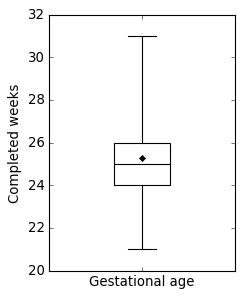

In [58]:
dpi=300; filetype = 'jpg'

medianprops = {'color': 'black', 'linewidth': 1}
meanpointprops = {'marker':'D', 'markersize' : 4, 'markeredgecolor':'black', 'markerfacecolor':'black'}
boxprops = {'color': 'black',  'linestyle': '-'}; whiskerprops = {'color': 'black', 'linestyle': '-'}
capprops = {'color': 'black', 'linestyle': '-'}; flierprops = {'color': 'black', 'marker': '.'}

fig,ax = plt.subplots(1,1, figsize=(3,4))
ax.boxplot(clin_data_combined['Gest Week_manual'], 
    widths=0.3,  whis = [0, 100], patch_artist = True, showfliers = True, showmeans = True,
    medianprops=medianprops, meanprops = meanpointprops, boxprops=boxprops, whiskerprops=whiskerprops, 
    capprops=capprops,)

ax.set_ylim(20, 32)
ax.set_xticks([1], ['Gestational age'])
ax.set_ylabel('Completed weeks')
fig.savefig(os.path.join (DIR_WRITE, f'gestational_age_ELBW_boxplot.{filetype}'), 
            dpi = dpi, format = filetype, bbox_inches='tight', pad_inches=0.1);

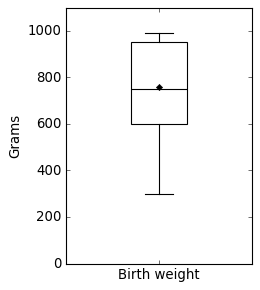

In [59]:
dpi=300; filetype = 'jpg'

medianprops = {'color': 'black', 'linewidth': 1}
meanpointprops = {'marker':'D', 'markersize' : 4, 'markeredgecolor':'black', 'markerfacecolor':'black'}
boxprops = {'color': 'black',  'linestyle': '-'}; whiskerprops = {'color': 'black', 'linestyle': '-'}
capprops = {'color': 'black', 'linestyle': '-'}; flierprops = {'color': 'black', 'marker': '.'}

fig,ax = plt.subplots(1,1, figsize=(3,4))
ax.boxplot(clin_data_combined['Birth weight_manual'], 
    widths=0.3,  whis = [0, 100], patch_artist = True, showfliers = True, showmeans = True,
    medianprops=medianprops, meanprops = meanpointprops, boxprops=boxprops, whiskerprops=whiskerprops, 
    capprops=capprops,)

ax.set_ylim(0, 1100)
ax.set_xticks([1], ['Birth weight'])
ax.set_ylabel('Grams')
fig.savefig(os.path.join (DIR_WRITE, f'birth_weight_ELBW_boxplot.{filetype}'), 
            dpi = dpi, format = filetype, bbox_inches='tight', pad_inches=0.1);

#### B. Antenatal care and delivery

##### 1. Antenatal steriods

0:no,
0.5:partial course,
1:full course

In [60]:
clin_data_combined['Antenatal steroid_manual'].value_counts(dropna=False)

Antenatal steroid_manual
0.0    33
1.0    10
NaN     7
0.5     5
Name: count, dtype: int64

##### 2. Maternal complications

1:abruption, 2:infection, 3:cardiovascular problem, 4:umbilical cord problem, 5:other

In [61]:
clin_data_combined['Maternal complications_manual'].value_counts(dropna=False)

Maternal complications_manual
0    23
1    20
2     4
5     4
4     2
3     2
Name: count, dtype: int64

##### 3. Born outside hospital

1:yes,
0:no

In [62]:
clin_data_combined['Born outside of hosp_manual'].value_counts(dropna=False)

Born outside of hosp_manual
0    48
1     7
Name: count, dtype: int64

##### 4. Mode of delivery
1:vaginal,
2:caesarean section

In [63]:
clin_data_combined['Mode of delivery_manual'].value_counts(dropna=False)

Mode of delivery_manual
2    28
1    27
Name: count, dtype: int64

#### C. Delivery unit care

##### 1. Who was the first responder and arrival of Cerny

In [64]:
# 1:parent/paramedic/other, 2:local paediatrician, 3:PCAM staff
clin_data_combined['First responder_manual'].value_counts(dropna=False)

First responder_manual
2    31
3    17
1     7
Name: count, dtype: int64

In [65]:
clin_data_combined['Age_at_Cerny_arrival'] = clin_data_combined['Arrival of PCAM_manual'] - \
                                             clin_data_combined['Date of Birth_manual']

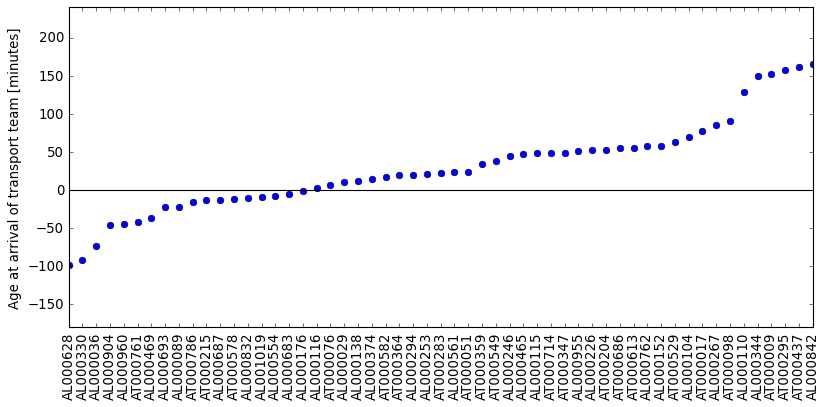

In [66]:
dpi=300; filetype = 'jpg'

fig,ax = plt.subplots(1,1, figsize=(12,5))
ax.plot(clin_data_combined['Age_at_Cerny_arrival'].sort_values()/ 1e9 / 60, marker = 'o', linestyle='')
ax.set_ylim(-180, 240)
plt.xticks(rotation = 90);
ax.axhline(y=0, color='black', linestyle='-')
ax.set_ylabel('Age at arrival of transport team [minutes]')

fig.savefig(os.path.join (DIR_WRITE, f'age_at_arrival_of transport_team.{filetype}'), 
            dpi = dpi, format = filetype, bbox_inches='tight', pad_inches=0.1);

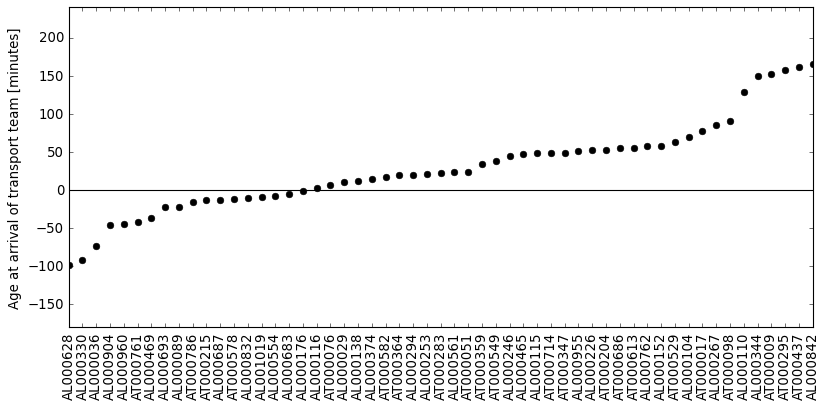

In [67]:
dpi=300; filetype = 'jpg'

fig,ax = plt.subplots(1,1, figsize=(12,5))
ax.plot(clin_data_combined['Age_at_Cerny_arrival'].sort_values()/ 1e9 / 60, color = 'black', 
        marker = 'o', linestyle='')
ax.set_ylim(-180, 240)
plt.xticks(rotation = 90);
ax.axhline(y=0, color='black', linestyle='-')
ax.set_ylabel('Age at arrival of transport team [minutes]')

fig.savefig(os.path.join (DIR_WRITE, f'age_at_arrival_of transport_team_bw.{filetype}'), 
            dpi = dpi, format = filetype, bbox_inches='tight', pad_inches=0.1);

In [68]:
clin_data_combined['PCAM at birth'] = np.where(clin_data_combined['Age_at_Cerny_arrival']< pd.to_timedelta(0), 1, 0)

In [69]:
# Cerny present at birth: 0:no, 1:yes
clin_data_combined['PCAM at birth'].value_counts()

PCAM at birth
0    37
1    18
Name: count, dtype: int64

In [70]:
# Cerny present by 15 minutes of age
sum(clin_data_combined['Age_at_Cerny_arrival'] <= pd.to_timedelta('15 min'))

23

In [71]:
# Cerny was not present at birth for those ones born outside hospital
clin_data_combined.groupby('Born outside of hosp_manual')['PCAM at birth'].value_counts()

Born outside of hosp_manual  PCAM at birth
0                            0                30
                             1                18
1                            0                 7
Name: count, dtype: int64

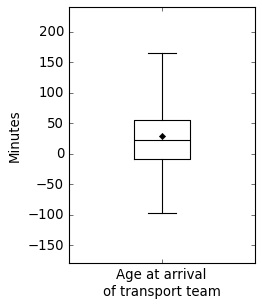

In [72]:
dpi=300; filetype = 'jpg'

medianprops = {'color': 'black', 'linewidth': 1}
meanpointprops = {'marker':'D', 'markersize' : 4, 'markeredgecolor':'black', 'markerfacecolor':'black'}
boxprops = {'color': 'black',  'linestyle': '-'}; whiskerprops = {'color': 'black', 'linestyle': '-'}
capprops = {'color': 'black', 'linestyle': '-'}; flierprops = {'color': 'black', 'marker': '.'}

fig,ax = plt.subplots(1,1, figsize=(3,4))

ax.boxplot(clin_data_combined['Age_at_Cerny_arrival']/ 1e9 / 60, widths=0.3, whis = [0, 100], 
           showfliers = False, showmeans = True,
           medianprops=medianprops, meanprops = meanpointprops, boxprops=boxprops, whiskerprops=whiskerprops, 
           capprops=capprops, )
ax.set_ylim(-180, 240)
ax.set_xticks([1], ['Age at arrival\nof transport team'])
ax.set_ylabel('Minutes')
fig.savefig(os.path.join (DIR_WRITE, f'age_at_arrival_of transport_team_boxplot.{filetype}'), 
            dpi = dpi, format = filetype, bbox_inches='tight', pad_inches=0.1);

##### 2. Intubation and surfactant administration

In [73]:
# 0-not intubated, 1-local pediatrician, 2-PCAM staff
clin_data_combined['Who performed intub_manual'].value_counts(dropna=False)

Who performed intub_manual
2    38
1    14
0     3
Name: count, dtype: int64

In [74]:
# Cases who were not intubated
clin_data_combined[clin_data_combined['Who performed intub_manual'] == 0].index

Index(['AL000253', 'AL000762', 'AT000051'], dtype='object', name='Ventilation ID')

In [75]:
# 0: no, 1:yes
clin_data_combined['Reintubation by PCAM_manual'].value_counts(dropna=False)

Reintubation by PCAM_manual
0    43
1    12
Name: count, dtype: int64

In [76]:
# Surfactant given prior to transport? 0: no, 1:yes
clin_data_combined['Surfactant admin_manual'].value_counts(dropna=False)

Surfactant admin_manual
1    52
0     3
Name: count, dtype: int64

In [77]:
clin_data_combined[clin_data_combined['Surfactant admin_manual'] == 0][['Gest Week_manual', 'Birth weight_manual',
                                                                        'Km_manual']]

,Gest Week_manual,Birth weight_manual,Km_manual
Ventilation ID,,,
AL000253,27,950,5
AL000762,26,600,79
AT000051,28,990,2


In [78]:
clin_data_combined['Age at surfactant'] = clin_data_combined['Time of surfactant_manual'] -\
clin_data_combined['Date of Birth_manual']

In [79]:
clin_data_combined['Age at surfactant'].describe()

count                           49
mean     0 days 01:03:08.571428571
std      0 days 00:52:33.854784228
min                0 days 00:09:00
25%                0 days 00:19:00
50%                0 days 00:55:00
75%                0 days 01:21:00
max                0 days 03:32:00
Name: Age at surfactant, dtype: object

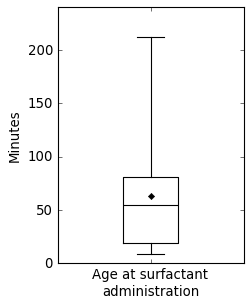

In [80]:
dpi=300; filetype = 'jpg'

medianprops = {'color': 'black', 'linewidth': 1}
meanpointprops = {'marker':'D', 'markersize' : 4, 'markeredgecolor':'black', 'markerfacecolor':'black'}
boxprops = {'color': 'black',  'linestyle': '-'}; whiskerprops = {'color': 'black', 'linestyle': '-'}
capprops = {'color': 'black', 'linestyle': '-'}; flierprops = {'color': 'black', 'marker': '.'}

fig,ax = plt.subplots(1,1, figsize=(3,4))

ax.boxplot(clin_data_combined['Age at surfactant'].dropna() / 1e9 / 60, widths=0.3, whis = [0, 100], 
           showfliers=False, showmeans=True,
           medianprops=medianprops, meanprops = meanpointprops, boxprops=boxprops, whiskerprops=whiskerprops, 
           capprops=capprops, )

ax.set_ylim(0, 240)
ax.set_xticks([1], ['Age at surfactant\nadministration'])
ax.set_ylabel('Minutes')
fig.savefig(os.path.join (DIR_WRITE, f'age_at_surfactant administration_boxplot.{filetype}'), 
            dpi = dpi, format = filetype, bbox_inches='tight', pad_inches=0.1);

##### 3. Chest compression and adrenaline bolus

In [81]:
# 0:no; 1:yes
clin_data_combined['Chest compression_manual'].value_counts(dropna=False)

Chest compression_manual
0    46
1     9
Name: count, dtype: int64

In [82]:
# 0:no; 1:yes
clin_data_combined['Adrenaline_manual'].value_counts(dropna=False)

Adrenaline_manual
0    48
1     7
Name: count, dtype: int64

#### D. Transport characteristics

##### 1. Distance travelled

In [83]:
clin_data_combined['Km_manual'].describe()

count     55.000000
mean      57.018182
std       40.295433
min        1.000000
25%       11.000000
50%       59.000000
75%       88.500000
max      121.000000
Name: Km_manual, dtype: float64

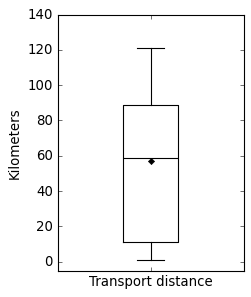

In [84]:
dpi=300; filetype = 'jpg'

medianprops = {'color': 'black', 'linewidth': 1}
meanpointprops = {'marker':'D', 'markersize' : 4, 'markeredgecolor':'black', 'markerfacecolor':'black'}
boxprops = {'color': 'black',  'linestyle': '-'}; whiskerprops = {'color': 'black', 'linestyle': '-'}
capprops = {'color': 'black', 'linestyle': '-'}; flierprops = {'color': 'black', 'marker': '.'}

fig,ax = plt.subplots(1,1, figsize=(3,4))

ax.boxplot(clin_data_combined['Km_manual'], widths=0.3, whis = [0, 100], 
           showfliers = False, showmeans = True,
           medianprops=medianprops, meanprops = meanpointprops, boxprops=boxprops, whiskerprops=whiskerprops, 
           capprops=capprops, )
ax.set_ylim(-5, 140)
ax.set_xticks([1], ['Transport distance'])
ax.set_ylabel('Kilometers')
fig.savefig(os.path.join (DIR_WRITE, f'transport distance_boxplot.{filetype}'), 
            dpi = dpi, format = filetype, bbox_inches='tight', pad_inches=0.1);

##### 2. Age at arrival

In [85]:
clin_data_combined['Age at arrival_NICU'] = clin_data_combined['End of transport_manual'] - \
    clin_data_combined['Date of Birth_manual']

In [86]:
clin_data_combined['Age at arrival_NICU'].describe()

count                           55
mean     0 days 03:17:56.727272727
std      0 days 01:07:36.228431795
min                0 days 01:29:00
25%                0 days 02:15:30
50%                0 days 03:15:00
75%                0 days 04:19:30
max                0 days 05:46:00
Name: Age at arrival_NICU, dtype: object

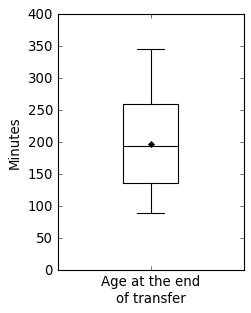

In [87]:
dpi=300; filetype = 'jpg'

medianprops = {'color': 'black', 'linewidth': 1}
meanpointprops = {'marker':'D', 'markersize' : 4, 'markeredgecolor':'black', 'markerfacecolor':'black'}
boxprops = {'color': 'black',  'linestyle': '-'}; whiskerprops = {'color': 'black', 'linestyle': '-'}
capprops = {'color': 'black', 'linestyle': '-'}; flierprops = {'color': 'black', 'marker': '.'}

fig,ax = plt.subplots(1,1, figsize=(3,4))

ax.boxplot(clin_data_combined['Age at arrival_NICU'].dropna() / 1e9 / 60, widths=0.3, whis = [0, 100], 
           showfliers=False, showmeans=True,
           medianprops=medianprops, meanprops = meanpointprops, boxprops=boxprops, whiskerprops=whiskerprops, 
           capprops=capprops, )

ax.set_ylim(0, 400)
ax.set_xticks([1], ['Age at the end\nof transfer'])
ax.set_ylabel('Minutes')
fig.savefig(os.path.join (DIR_WRITE, f'age_at_arrival_NICU_boxplot.{filetype}'), 
            dpi = dpi, format = filetype, bbox_inches='tight', pad_inches=0.1);

#### E. Cardiovascular care and sedation during transport

In [88]:
# 0:no; 1:yes
clin_data_combined['Fluid bolus_manual'].value_counts(dropna=False)

Fluid bolus_manual
0    37
1    18
Name: count, dtype: int64

In [89]:
# 0:no; 1:yes
clin_data_combined['CV support drug_manual'].value_counts(dropna=False)

CV support drug_manual
0    49
1     6
Name: count, dtype: int64

In [90]:
# 0:no; 1:yes
clin_data_combined['Fentanyl_manual'].value_counts(dropna=False)

Fentanyl_manual
0    43
1    12
Name: count, dtype: int64

#### F. Survival to discharge

In [91]:
# 0: survived; 1: died
clin_data_combined['Death_outcome'].value_counts(dropna=False)

Death_outcome
0.0    30
1.0    22
NaN     3
Name: count, dtype: int64

In [92]:
((sum(clin_data_combined['Death_outcome']==0) / len(clin_data_combined)),
(sum(clin_data_combined['Death_outcome']==1) / len(clin_data_combined)))

(0.5454545454545454, 0.4)

In [93]:
clin_data_combined.groupby('Gest Week_manual')['Death_outcome'].value_counts(dropna=False)

Gest Week_manual  Death_outcome
21                1.0              1
22                1.0              2
23                1.0              6
                  NaN              1
24                0.0              5
                  1.0              5
25                0.0              7
                  1.0              3
                  NaN              1
26                0.0              6
                  1.0              4
                  NaN              1
27                0.0              5
                  1.0              1
28                0.0              4
29                0.0              1
30                0.0              1
31                0.0              1
Name: count, dtype: int64

In [94]:
# Export processed combined clinical dataset 
with pd.ExcelWriter(os.path.join(DIR_WRITE, f'mortality_ELBW.xlsx')) as writer:
    clin_data_combined['Death_outcome'].value_counts(dropna=False).to_excel(writer, sheet_name='survived_0_died_1')
    clin_data_combined.groupby('Gest Week_manual')['Death_outcome'].value_counts(dropna=False).to_excel(writer, 
                                                                                        sheet_name='death_by_week')

##### Comparison with national statistics

In our cohort 30 / 55 survived
Nationally, inborn infants (2020) 288 / 374 survived

In [95]:
stats.fisher_exact([[30, 55], [288, 374]])

SignificanceResult(statistic=0.7083333333333334, pvalue=0.16301379295668408)

#### G. Long-term morbidities

Morbidity data is only available for babies who survived to discharge

In [96]:
clin_data_combined['Death_outcome'].value_counts(dropna=False)

Death_outcome
0.0    30
1.0    22
NaN     3
Name: count, dtype: int64

In [97]:
outcome[outcome['Death_outcome'] ==0].describe().loc['count']

Patient report_outcome          30.0
Death_outcome                   30.0
Neurodev. Impairment_outcome     8.0
Length of AB (days)_outcome     24.0
Inv. Vent (days)_outcome        24.0
Sepsis_outcome                  28.0
IVH_outcome                     28.0
ROP_outcome                     27.0
NEC_outcome                     28.0
BPD_outcome                     28.0
Name: count, dtype: float64

In [98]:
clin_data_combined[['Death_outcome', 'IVH_outcome']].value_counts(dropna=False)

Death_outcome  IVH_outcome
1.0            NaN            22
0.0            0.0            14
               1.0             7
               3.0             4
               5.0             3
NaN            NaN             3
0.0            NaN             2
Name: count, dtype: int64

In [99]:
clin_data_combined[['Death_outcome', 'ROP_outcome']].value_counts(dropna=False)

Death_outcome  ROP_outcome
1.0            NaN            22
0.0            0.0            19
               1.0             8
               NaN             3
NaN            NaN             3
Name: count, dtype: int64

In [100]:
clin_data_combined[['Death_outcome', 'BPD_outcome']].value_counts(dropna=False)

Death_outcome  BPD_outcome
1.0            NaN            22
0.0            0.0            19
               1.0             9
NaN            NaN             3
0.0            NaN             2
Name: count, dtype: int64

In [101]:
clin_data_combined[['Death_outcome', 'NEC_outcome']].value_counts(dropna=False)

Death_outcome  NEC_outcome
0.0            0.0            22
1.0            NaN            22
0.0            1.0             6
NaN            NaN             3
0.0            NaN             2
Name: count, dtype: int64

In [102]:
clin_data_combined['Inv. Vent (days)_outcome'].describe()

count    24.000000
mean      9.208333
std      10.942455
min       0.000000
25%       1.000000
50%       4.500000
75%      13.250000
max      40.000000
Name: Inv. Vent (days)_outcome, dtype: float64

### 10. Compare selected parameters at arrival of the tranport service to referring hopital versus at handover to NICU

#### A. Body temperature

In [103]:
temperature_arrival = vital_parameters['At arrival of PCAM']['Body temperature (°C)']
temperature_arrival.describe()

count    54.000000
mean     35.377778
std       1.821742
min      28.500000
25%      34.700000
50%      35.900000
75%      36.475000
max      38.100000
Name: Body temperature (°C), dtype: float64

In [104]:
temperature_handover = vital_parameters['At arrival to NICU']['Body temperature (°C)']
temperature_handover.describe()

count    54.000000
mean     36.461111
std       1.143054
min      33.100000
25%      36.025000
50%      36.700000
75%      37.300000
max      38.300000
Name: Body temperature (°C), dtype: float64

In [105]:
stats.mannwhitneyu(temperature_arrival.dropna(), temperature_handover.dropna())

MannwhitneyuResult(statistic=849.0, pvalue=0.00018352573592132903)

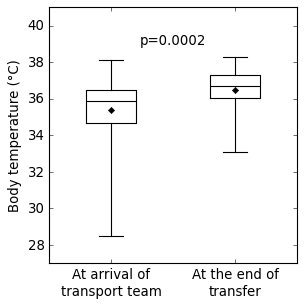

In [106]:
dpi=300; filetype = 'jpg'

medianprops = {'color': 'black', 'linewidth': 1}
meanpointprops = {'marker':'D', 'markersize' : 4, 'markeredgecolor':'black', 'markerfacecolor':'black'}
boxprops = {'color': 'black',  'linestyle': '-'}; whiskerprops = {'color': 'black', 'linestyle': '-'}
capprops = {'color': 'black', 'linestyle': '-'}; flierprops = {'color': 'black', 'marker': '.'}

fig,ax = plt.subplots(1,1, figsize=(4,4))

ax.boxplot([vital_parameters['At arrival of PCAM']['Body temperature (°C)'].dropna().values,
            vital_parameters['At arrival to NICU']['Body temperature (°C)'].dropna().values],
            widths=0.4, whis = [0, 100], 
            showfliers=False, showmeans=True,
            medianprops=medianprops, meanprops = meanpointprops, boxprops=boxprops, whiskerprops=whiskerprops, 
            capprops=capprops, )

ax.set_ylim(27, 41)
ax.set_xticks([1,2], ['At arrival of\ntransport team', 'At the end of\ntransfer'])
ax.set_ylabel('Body temperature (°C)')

ax.text(1.5, 39, 'p=0.0002', horizontalalignment ='center')

fig.savefig(os.path.join(DIR_WRITE, f'Body_temperature_boxplot.{filetype}'), dpi = dpi, format = filetype,
           bbox_inches='tight', pad_inches=0.1);

#### B. Respiratory support

In [107]:
vital_parameters['At arrival of PCAM']['Resp. support (1-mask, 2-cPAP, 3-intub)'].value_counts(dropna=False)

Resp. support (1-mask, 2-cPAP, 3-intub)
2    22
3    17
1    11
0     5
Name: count, dtype: int64

In [108]:
vital_parameters['At arrival to NICU']['Resp. support (1-cPAP, 2-intub.)'].value_counts(dropna=False)

Resp. support (1-cPAP, 2-intub.)
2    45
3     7
1     3
Name: count, dtype: int64

#### C. Blood gases

In [109]:
blood_gases_arrival = blood_gases_manual['At arrival of PCAM'][['pH', 'pCO2', 'BE']]
blood_gases_arrival.describe()

parameter,pH,pCO2,BE
count,47.000000,47.000000,46.000000
mean,7.157468,57.265957,-8.386957
std,0.138315,17.780611,4.673690
min,6.550000,33.900000,-21.000000
25%,7.101000,46.700000,-11.950000
50%,7.193000,51.700000,-7.750000
75%,7.240000,64.250000,-5.000000
max,7.370000,130.000000,-0.300000


In [110]:
blood_gases_handover = blood_gases_manual['At arrival to NICU'][['pH', 'pCO2', 'BE']]
blood_gases_handover.describe()

parameter,pH,pCO2,BE
count,50.000000,50.000000,50.000000
mean,7.255820,49.896000,-4.906000
std,0.142474,12.948027,5.611265
min,6.681000,31.300000,-25.100000
25%,7.203250,40.850000,-7.300000
50%,7.270000,48.750000,-3.650000
75%,7.321500,56.250000,-1.025000
max,7.478000,89.500000,3.400000


In [111]:
# Export processed combined clinical dataset 
with pd.ExcelWriter(os.path.join(DIR_WRITE, f'blood_gases_arrival_handover_ELBW.xlsx')) as writer:
    blood_gases_arrival.describe().to_excel(writer, sheet_name='arrival_of_team')
    blood_gases_handover.describe().to_excel(writer, sheet_name='handover_on_NICU')

##### pH

In [112]:
stats.mannwhitneyu(blood_gases_arrival['pH'].dropna(), blood_gases_handover['pH'].dropna())

MannwhitneyuResult(statistic=601.5, pvalue=3.516696109595749e-05)

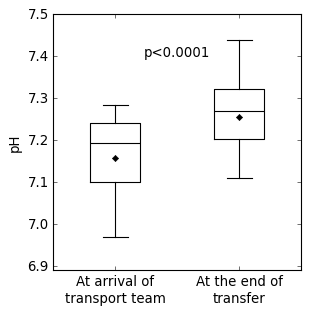

In [113]:
dpi=300; filetype = 'jpg'

medianprops = {'color': 'black', 'linewidth': 1}
meanpointprops = {'marker':'D', 'markersize' : 4, 'markeredgecolor':'black', 'markerfacecolor':'black'}
boxprops = {'color': 'black',  'linestyle': '-'}; whiskerprops = {'color': 'black', 'linestyle': '-'}
capprops = {'color': 'black', 'linestyle': '-'}; flierprops = {'color': 'black', 'marker': '.'}

fig,ax = plt.subplots(1,1, figsize=(4,4))

ax.boxplot([blood_gases_arrival['pH'].dropna().values, blood_gases_handover['pH'].dropna().values],
            widths=0.4, whis = [5, 95], 
            showfliers=False, showmeans=True,
            medianprops=medianprops, meanprops = meanpointprops, boxprops=boxprops, whiskerprops=whiskerprops, 
            capprops=capprops, )

ax.set_ylim(6.89, 7.5)
ax.set_xticks([1,2], ['At arrival of\ntransport team', 'At the end of\ntransfer'])
ax.set_ylabel('pH')

ax.text(1.5, 7.4, 'p<0.0001', horizontalalignment ='center')

fig.savefig(os.path.join(DIR_WRITE, f'pH_boxplot.{filetype}'), dpi = dpi, format = filetype, bbox_inches='tight', pad_inches=0.1);

##### pCO2

In [114]:
stats.mannwhitneyu(blood_gases_arrival['pCO2'].dropna(), blood_gases_handover['pCO2'].dropna())

MannwhitneyuResult(statistic=1514.5, pvalue=0.014395256643367233)

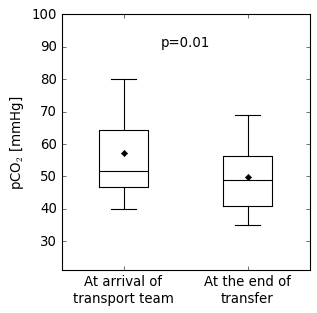

In [115]:
dpi=300; filetype = 'jpg'

medianprops = {'color': 'black', 'linewidth': 1}
meanpointprops = {'marker':'D', 'markersize' : 4, 'markeredgecolor':'black', 'markerfacecolor':'black'}
boxprops = {'color': 'black',  'linestyle': '-'}; whiskerprops = {'color': 'black', 'linestyle': '-'}
capprops = {'color': 'black', 'linestyle': '-'}; flierprops = {'color': 'black', 'marker': '.'}

fig,ax = plt.subplots(1,1, figsize=(4,4))

ax.boxplot([blood_gases_arrival['pCO2'].dropna(), blood_gases_handover['pCO2'].dropna()],
            widths=0.4, whis = [5, 95], 
            showfliers=False, showmeans=True,
            medianprops=medianprops, meanprops = meanpointprops, boxprops=boxprops, whiskerprops=whiskerprops, 
            capprops=capprops, )

ax.set_ylim(21, 100)
ax.set_xticks([1,2], ['At arrival of\ntransport team', 'At the end of\ntransfer'])
ax.set_ylabel('pCO$_2$ [mmHg]')

ax.text(1.5, 90, 'p=0.01', horizontalalignment ='center')

fig.savefig(os.path.join(DIR_WRITE, f'pCO2_boxplot.{filetype}'), dpi = dpi, format = filetype, bbox_inches='tight', pad_inches=0.1);

##### Base excess (BE)

In [116]:
stats.mannwhitneyu(blood_gases_arrival['BE'].dropna(), blood_gases_handover['BE'].dropna())

MannwhitneyuResult(statistic=638.0, pvalue=0.0001754012612514757)

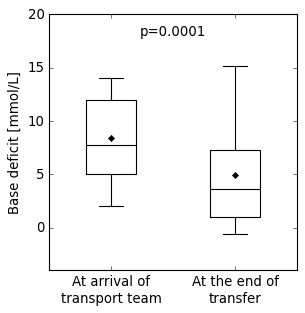

In [117]:
dpi=300; filetype = 'jpg'

medianprops = {'color': 'black', 'linewidth': 1}
meanpointprops = {'marker':'D', 'markersize' : 4, 'markeredgecolor':'black', 'markerfacecolor':'black'}
boxprops = {'color': 'black',  'linestyle': '-'}; whiskerprops = {'color': 'black', 'linestyle': '-'}
capprops = {'color': 'black', 'linestyle': '-'}; flierprops = {'color': 'black', 'marker': '.'}

fig,ax = plt.subplots(1,1, figsize=(4,4))

ax.boxplot([-1*blood_gases_arrival['BE'].dropna(), -1*blood_gases_handover['BE'].dropna()],
            widths=0.4, whis = [5, 95], 
            showfliers=False, showmeans=True,
            medianprops=medianprops, meanprops = meanpointprops, boxprops=boxprops, whiskerprops=whiskerprops, 
            capprops=capprops, )

ax.set_ylim(-4, 20)
ax.set_xticks([1,2], ['At arrival of\ntransport team', 'At the end of\ntransfer'])
ax.set_ylabel('Base deficit [mmol/L]')

ax.text(1.5, 18, 'p=0.0001', horizontalalignment ='center')

fig.savefig(os.path.join(DIR_WRITE, f'BE_ELBW_boxplot.{filetype}'), dpi = dpi, format = filetype, bbox_inches='tight', pad_inches=0.1);

### 11. Produce the figures for the paper

#### A. Figure 1

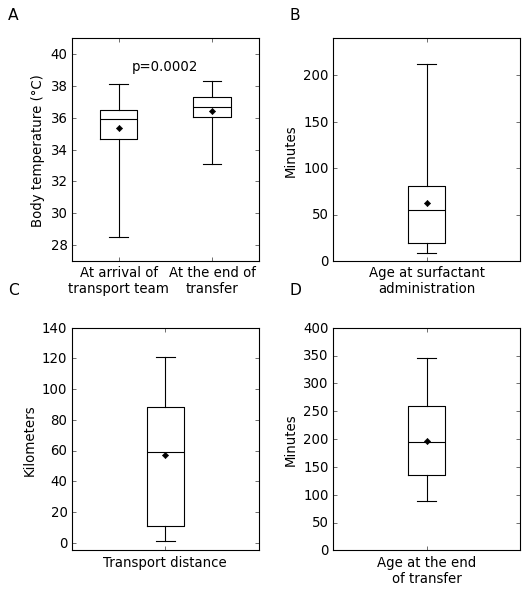

In [118]:
dpi=300; filetype = 'pdf'

medianprops = {'color': 'black', 'linewidth': 1}
meanpointprops = {'marker':'D', 'markersize' : 4, 'markeredgecolor':'black', 'markerfacecolor':'black'}
boxprops = {'color': 'black',  'linestyle': '-'}; whiskerprops = {'color': 'black', 'linestyle': '-'}
capprops = {'color': 'black', 'linestyle': '-'}; flierprops = {'color': 'black', 'marker': '.'}

fig,axes = plt.subplots(2,2, figsize=(8,8))
fig.subplots_adjust(left=0.2, bottom=None, right=None, top=None, wspace=0.4, hspace=0.3)

# Figure 1A
axes[0,0].boxplot([vital_parameters['At arrival of PCAM']['Body temperature (°C)'].dropna().values,
    vital_parameters['At arrival to NICU']['Body temperature (°C)'].dropna().values],
    widths=0.4, whis = [0, 100], showfliers=False, showmeans=True, medianprops=medianprops, 
    meanprops = meanpointprops, boxprops=boxprops, whiskerprops=whiskerprops, capprops=capprops, )
axes[0,0].set_ylim(27, 41)
axes[0,0].set_xticks([1,2], ['At arrival of\ntransport team', 'At the end of\ntransfer'])
axes[0,0].set_ylabel('Body temperature (°C)')
axes[0,0].text(1.5, 39, 'p=0.0002', horizontalalignment ='center')

# Figure 1B
axes[0,1].boxplot(clin_data_combined['Age at surfactant'].dropna() / 1e9 / 60, widths=0.2, whis = [0, 100], showfliers=False, 
    showmeans=True, medianprops=medianprops, meanprops = meanpointprops, boxprops=boxprops, whiskerprops=whiskerprops, 
    capprops=capprops, )
axes[0,1].set_ylim(0, 240)
axes[0,1].set_xticks([1], ['Age at surfactant\nadministration'])
axes[0,1].set_ylabel('Minutes')

# Figure 1C
axes[1,0].boxplot(clin_data_combined['Km_manual'], widths=0.2, whis = [0, 100], showfliers = False, showmeans = True,
    medianprops=medianprops, meanprops = meanpointprops, boxprops=boxprops, whiskerprops=whiskerprops, capprops=capprops, )
axes[1,0].set_ylim(-5, 140)
axes[1,0].set_xticks([1], ['Transport distance'])
axes[1,0].set_ylabel('Kilometers')

# Figure 1D
axes[1,1].boxplot(clin_data_combined['Age at arrival_NICU'].dropna() / 1e9 / 60, widths=0.2, whis = [0, 100], 
    showfliers=False, showmeans=True, medianprops=medianprops, meanprops = meanpointprops, boxprops=boxprops, 
    whiskerprops=whiskerprops, capprops=capprops, )
axes[1,1].set_ylim(0, 400)
axes[1,1].set_xticks([1], ['Age at the end\nof transfer'])
axes[1,1].set_ylabel('Minutes')

fig.text(0.1, 0.93, 'A', fontsize=14); fig.text(0.54, 0.93, 'B', fontsize=14)
fig.text(0.1, 0.50, 'C', fontsize=14); fig.text(0.54, 0.50, 'D', fontsize=14)

fig.savefig(os.path.join(DIR_WRITE, f'Figure_1.{filetype}'), dpi = dpi, format = filetype,
           bbox_inches='tight', pad_inches=0.1);

#### B. Figure 2

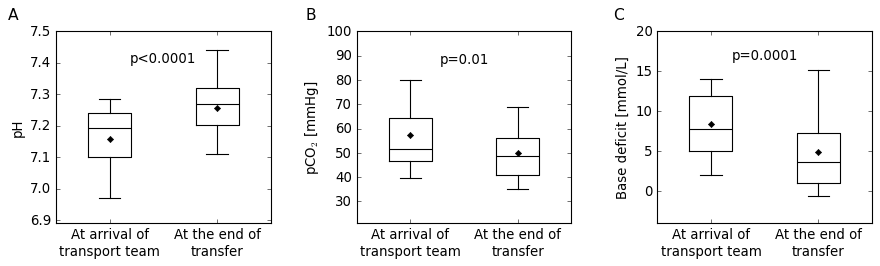

In [119]:
dpi=300; filetype = 'pdf'

medianprops = {'color': 'black', 'linewidth': 1}
meanpointprops = {'marker':'D', 'markersize' : 4, 'markeredgecolor':'black', 'markerfacecolor':'black'}
boxprops = {'color': 'black',  'linestyle': '-'}; whiskerprops = {'color': 'black', 'linestyle': '-'}
capprops = {'color': 'black', 'linestyle': '-'}; flierprops = {'color': 'black', 'marker': '.'}

fig,ax = plt.subplots(1,3, figsize=(12,3))
fig.subplots_adjust(left=0.05, bottom=None, right=None, top=None, wspace=0.4, hspace=0.3)

# Figure 2A
ax[0].boxplot([blood_gases_arrival['pH'].dropna().values, blood_gases_handover['pH'].dropna().values], widths=0.4, whis = [5, 95], 
    showfliers=False, showmeans=True, medianprops=medianprops, meanprops = meanpointprops, boxprops=boxprops, 
    whiskerprops=whiskerprops, capprops=capprops, )
ax[0].set_ylim(6.89, 7.5)
ax[0].set_xticks([1,2], ['At arrival of\ntransport team', 'At the end of\ntransfer'])
ax[0].set_ylabel('pH')
ax[0].text(1.5, 7.4, 'p<0.0001', horizontalalignment ='center')

# Figure 2B
ax[1].boxplot([blood_gases_arrival['pCO2'].dropna(), blood_gases_handover['pCO2'].dropna()], widths=0.4, whis = [5, 95], 
    showfliers=False, showmeans=True, medianprops=medianprops, meanprops = meanpointprops, boxprops=boxprops, 
    whiskerprops=whiskerprops, capprops=capprops, )
ax[1].set_ylim(21, 100)
ax[1].set_xticks([1,2], ['At arrival of\ntransport team', 'At the end of\ntransfer'])
ax[1].set_ylabel('pCO$_2$ [mmHg]')
ax[1].text(1.5, 87, 'p=0.01', horizontalalignment ='center')

# Figure 2C
ax[2].boxplot([-1*blood_gases_arrival['BE'].dropna(), -1*blood_gases_handover['BE'].dropna()], widths=0.4, whis = [5, 95], 
    showfliers=False, showmeans=True, medianprops=medianprops, meanprops = meanpointprops, boxprops=boxprops, whiskerprops=whiskerprops, 
            capprops=capprops, )

ax[2].set_ylim(-4, 20)
ax[2].set_xticks([1,2], ['At arrival of\ntransport team', 'At the end of\ntransfer'])
ax[2].set_ylabel('Base deficit [mmol/L]')
ax[2].text(1.5, 16.5, 'p=0.0001', horizontalalignment ='center')

fig.text(0, 0.95, 'A', fontsize=14); fig.text(0.31, 0.95, 'B', fontsize=14); fig.text(0.63, 0.95, 'C', fontsize=14); 

fig.savefig(os.path.join(DIR_WRITE, f'Figure_2.{filetype}'), dpi = dpi, format = filetype,
    bbox_inches='tight', pad_inches=0.1);